In [1]:
import os, sys, keras
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [2]:
from graphTools import *
from layerTools import *

In [103]:

# Read in graphs
graph_files = glob.glob('qm9graph/*.csv')[0:1000]
mygraphs = [readgraph(fname) for fname in graph_files]
headers_onehot_dict, matrices_onehot_dict, mygraphs_standardized = standardize_graphs(mygraphs, max_size=29)
headers_padded = np.array([i['header'] for i in mygraphs_standardized])
matrices_padded = np.array([i['matrix'] for i in mygraphs_standardized])
connectivities_padded = np.array([i['connectivity'] for i in mygraphs_standardized])
origHeaders_padded = np.array([i['origHeader'] for i in mygraphs_standardized])
origMatrices_padded = np.array([i['origMatrix'] for i in mygraphs_standardized])
print headers_padded.shape
print matrices_padded.shape
print connectivities_padded.shape

Header One-Hot Map: {8.0: array([0., 0., 0., 1., 0.]), 1.0: array([1., 0., 0., 0., 0.]), 9.0: array([0., 0., 0., 0., 1.]), 6.0: array([0., 1., 0., 0., 0.]), 7.0: array([0., 0., 1., 0., 0.])}
Bond One-Hot Map: {1.0: array([1., 0., 0.]), 2.0: array([0., 1., 0.]), 3.0: array([0., 0., 1.])}
Graph Size: 29
Number of dropped graphs: 0
(1000, 29, 5)
(1000, 29, 29, 3)
(1000, 29, 29)


In [192]:
from layerTools import generate_gc_atom_layer
inital_atom_layer_1 = generate_gc_atom_layer(num_nodes=29, atom_hidden_length=5, bond_hidden_length=3, hide_atoms=False,\
                      message_dense_resize=5, atom_dense_resize=None,  nonlinear_state_update = False)
dense_read = keras.layers.Dense(32,activation='relu')(inital_atom_layer_1.output)
softmax_ouput = keras.layers.Dense(5,activation='softmax')(dense_read)


final_model = keras.models.Model(inputs=inital_atom_layer_1.inputs, outputs=[softmax_ouput])

combined shape is (?, 29, 10)
bond_hiddens_input shape is (?, 29, 29, 3)
atom_hiddens_input shape is (?, 29, 5)
connectivity_input shape is (?, 29, 29)
message_to_out shape is (?, 29, 5)


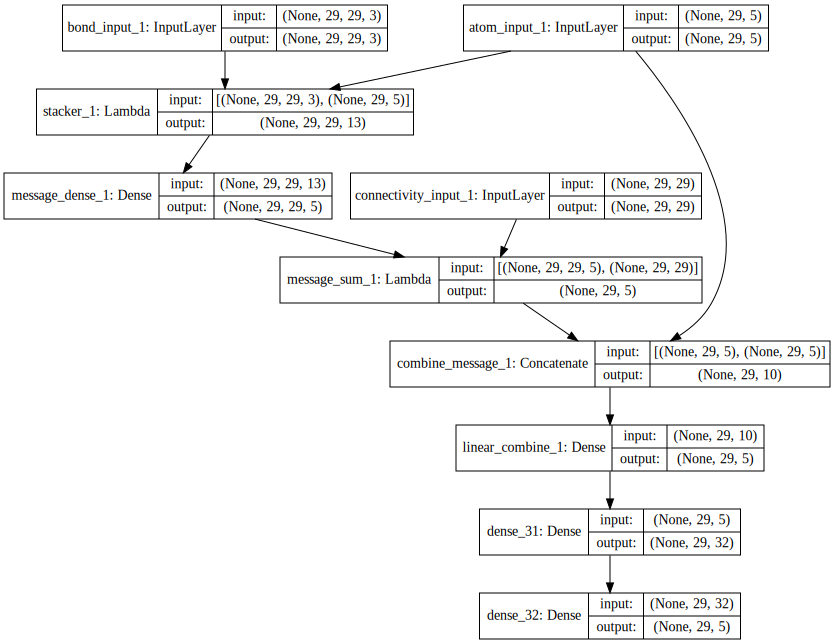

In [193]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(final_model,show_shapes=True).create(prog='dot', format='svg'))


In [194]:
final_model.predict([matrices_padded, headers_padded, connectivities_padded])[0]

array([[0.1750212 , 0.20989479, 0.19894926, 0.23941587, 0.1767189 ],
       [0.17653237, 0.21615066, 0.2551099 , 0.2707561 , 0.08145095],
       [0.20922959, 0.20975462, 0.24628009, 0.2110709 , 0.12366485],
       [0.17653237, 0.21615066, 0.2551099 , 0.2707561 , 0.08145095],
       [0.16978125, 0.21143371, 0.19737393, 0.2555654 , 0.16584575],
       [0.19891453, 0.21559583, 0.25664717, 0.23587132, 0.09297116],
       [0.16530502, 0.21253638, 0.2394689 , 0.2876955 , 0.09499424],
       [0.19031103, 0.208367  , 0.24318099, 0.24051432, 0.11762671],
       [0.19031103, 0.208367  , 0.24318099, 0.24051432, 0.11762671],
       [0.23939127, 0.20936109, 0.21219324, 0.2012115 , 0.13784291],
       [0.22377427, 0.20312333, 0.20555672, 0.2172423 , 0.1503034 ],
       [0.22377427, 0.20312333, 0.20555672, 0.2172423 , 0.1503034 ],
       [0.22377427, 0.20312333, 0.20555672, 0.2172423 , 0.1503034 ],
       [0.22377427, 0.20312333, 0.20555672, 0.2172423 , 0.1503034 ],
       [0.22377427, 0.20312333, 0.

In [195]:
np.random.seed(3)
# get random partition
msk = np.random.rand(np.shape(headers_padded)[0]) < 0.75

In [196]:
# test and train split
train_matrices_padded = matrices_padded[msk,:,:]
train_headers_padded = headers_padded[msk,:]
train_connectivities_padded = connectivities_padded[msk,:,:]
test_matrices_padded = matrices_padded[~msk,:,:]
test_headers_padded = headers_padded[~msk,:]
test_connectivities_padded = connectivities_padded[~msk,:,:]

In [197]:
test_matrices_padded.shape

(231, 29, 29, 3)

In [198]:
final_model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy','categorical_crossentropy'])

train_res = final_model.fit([train_matrices_padded, 
                             train_headers_padded*0.0, train_connectivities_padded],
                            train_headers_padded, epochs=50, 
                            batch_size=100,
                            validation_split=0.1,
                            verbose=True)

Train on 692 samples, validate on 77 samples
Epoch 1/50
692/692 [==============================] - 2s 3ms/step - loss: 0.9990 - categorical_accuracy: 0.5863 - categorical_crossentropy: 0.9990 - val_loss: 0.9787 - val_categorical_accuracy: 0.7179 - val_categorical_crossentropy: 0.9787
Epoch 2/50
692/692 [==============================] - 0s 72us/step - loss: 0.9780 - categorical_accuracy: 0.7186 - categorical_crossentropy: 0.9780 - val_loss: 0.9564 - val_categorical_accuracy: 0.7179 - val_categorical_crossentropy: 0.9564
Epoch 3/50
692/692 [==============================] - 0s 81us/step - loss: 0.9544 - categorical_accuracy: 0.7186 - categorical_crossentropy: 0.9544 - val_loss: 0.9317 - val_categorical_accuracy: 0.7179 - val_categorical_crossentropy: 0.9317
Epoch 4/50
692/692 [==============================] - 0s 68us/step - loss: 0.9282 - categorical_accuracy: 0.7186 - categorical_crossentropy: 0.9282 - val_loss: 0.9045 - val_categorical_accuracy: 0.7179 - val_categorical_crossentropy:

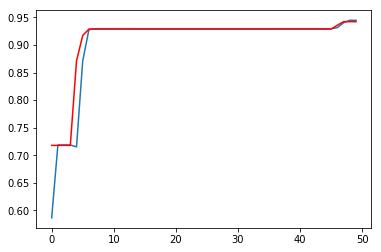

In [199]:
import matplotlib.pyplot as plt
plt.plot(train_res.history['categorical_accuracy'])
plt.plot(train_res.history['val_categorical_accuracy'],'r')
plt.show()

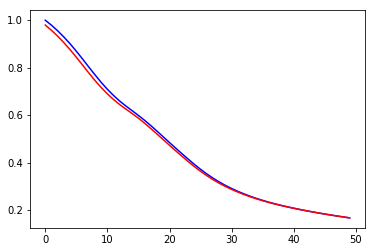

In [200]:
import matplotlib.pyplot as plt
plt.plot(train_res.history['categorical_crossentropy'],'b')
plt.plot(train_res.history['val_categorical_crossentropy'],'r')
plt.show()

In [201]:
test_predictions = final_model.predict([test_matrices_padded, test_headers_padded, test_connectivities_padded])

In [202]:
test_class_pred = test_predictions.argmax(axis=2)
print(test_class_pred.shape)

(231, 29)


In [203]:
test_class_act = test_headers_padded.argmax(axis=2)
print(test_class_act.shape)

(231, 29)


In [207]:
err_rate = 100*np.sum(np.sum(test_errors))/float(test_class_act.shape[0]*test_class_act.shape[1])
print('test error rate is ' + str(err_rate))

test error rate is 7.687714584266309


In [ ]:
#Generator

def image_categorical_crossentropy(y_true, y_pred):
    # Boilerplate off the internet to do crossentropy for multi-classification tasks,
    # in this case assigning one-hot atom labels to atoms
    __EPS = 1e-5
    y_pred = K.clip(y_pred, __EPS, 1 - __EPS)
    return -K.mean(y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred))
    
def gen_generator_model(num_nodes=29, input_shape=(1,), BO_dense_resize=200, BO_softmax_resize=4, labelator=None, labelatorTrainable=False):
    # Creates a Generator model. I chose the architecture arbitrarily
    # The architecture is random vector -> dense BO matrix -> softmax to dense 3D BO matrix
    # -> symmetrize -> dense -> dense to 29x29x6 matrix.
    
    inputLayer = keras.layers.Input(shape=input_shape)

    output__ = keras.layers.Dense(num_nodes*num_nodes, activation='relu')(inputLayer)
    output_ = keras.layers.Reshape((num_nodes,num_nodes))(output__)
    output_1 = keras.layers.Lambda(lambda x: K.expand_dims(x + K.permute_dimensions(x,(0,2,1)), axis=3))(output_)
    output_1_interpret = keras.layers.Dense(BO_dense_resize)(output_1)
    #print output_1
    #output_as_BO_mat = keras.layers.Dense(BO_dense_resize, activation='relu')(output_1)
    #output_as_BO_mat_stacked = keras.layers.Lambda(lambda x: K.concatenate([x, K.permute_dimensions(x,(0,2,1,3))], axis=3))(output_as_BO_mat)
    
    BO_mat_softmax_ = keras.layers.Dense(BO_softmax_resize, activation='softmax')(output_1_interpret)
    
    # Symmetrize the BO matrix
    BO_mat_softmax = keras.layers.Lambda(lambda x: (x+K.permute_dimensions(x,(0,2,1,3)))/2.0)(BO_mat_softmax_)
    
    connectivity = keras.layers.Lambda(lambda x: K.sum(x[:,:,:,1:], axis=3))(BO_mat_softmax)
    assert len(inputLayer.shape) == 2, "Unhandled Input Layer size."

    annotations__ = keras.layers.Dense(num_nodes)(inputLayer)
    annotations_ = keras.layers.Reshape((num_nodes,1))(annotations__)
    annotations = keras.layers.Dense(6, activation='softmax')(annotations_)
    if labelator == 'default':
        pass
    else:
        # Labelator is a pretrained network (legacy code)
        if labelator == None:
            annotations = keras.layers.Lambda(lambda x: x*0)(annotations)
            annotations.trainable = False
        else:
            # Labelator is an NN.
            labelator.trainable = labelatorTrainable
            annotations = labelator([BO_mat_softmax, annotations, connectivity])[1]
    model = keras.models.Model(inputs=inputLayer, outputs=[BO_mat_softmax, annotations, connectivity])
    return model

generator_input = keras.layers.Input(shape=(15,))
#bond_hiddens_input = keras.layers.Input(shape=(num_nodes,num_nodes,bond_hidden_length))
#atom_hiddens_input = keras.layers.Input(shape=(num_nodes,atom_hidden_length))
#connectivity_input = keras.layers.Input(shape=(num_nodes,num_nodes))


# Construct generator portion of GAN
myGen_intermediate = gen_generator_model(num_nodes=29, input_shape=(15,), BO_dense_resize=30, BO_softmax_resize=4,\
                            labelator=None, labelatorTrainable=False)
myGen_conv_1 = generate_gc_model(num_nodes=29, atom_hidden_length=6, bond_hidden_length=4, hide_atoms=False,\
                      message_dense_resize=30, atom_dense_resize=30, bond_dense_resize=1000, do_readout = False)

myGen_intermediate_output = myGen_intermediate(generator_input)
myGen_output_1 = myGen_conv_1(myGen_intermediate_output)
#myGen_output_2 = myGen_conv_1(myGen_output_1)
myGen = keras.models.Model(inputs=generator_input, outputs=myGen_output_1)

# Construct discriminator portion of GAN
myDisc = generate_gc_model(num_nodes=29, atom_hidden_length=6, bond_hidden_length=4, hide_atoms=False,\
                      message_dense_resize=30, atom_dense_resize=30, bond_dense_resize=None, do_readout = True)

myDisc.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['mean_squared_error', 'mean_absolute_error','binary_crossentropy'])

# Hook everything up together
myGenOutput = myGen(generator_input)
myDiscOutput = myDisc(myGenOutput)
myBigModel = keras.models.Model(inputs=generator_input, outputs=myDiscOutput)

myDisc.trainable = False

# Compile the GAN
myBigModel.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['mean_squared_error', 'mean_absolute_error','binary_crossentropy'])
#myDisc.trainable = True
#inputs = np.random.random((len(connectivities_padded),))


# Input the training data
inputs = [matrices_padded, headers_padded, connectivities_padded]

def train_discriminator(D, G, noise_in):
    fakeInputs = G.predict(noise_in)
    allInputs = [np.vstack((i,j)) for i,j in zip(inputs, fakeInputs)]
    
    allOutputs = [1]*len(inputs[0]) + [0]*len(fakeInputs[0])
    inputObjects = zip(*allInputs)

    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(inputObjects, allOutputs, test_size=0.33)

    D.fit(map(list,zip(*X_train)),y_train, epochs=1, verbose=True)

# Train the GAN
for j in range(10):
    print "Iteration:", j
    noise_input = np.random.normal(0,1,(len(inputs[0]),15))
    train_discriminator(myDisc,myGen,noise_input)
    myBigModel.fit(noise_input, [1]*len(noise_input), epochs=1, verbose=True)
print "done"

In [ ]:
gen_onehot_dict_default(headers_padded)